### Task 2: Trotter error scaling and higher order Trotterization formulas

- Implement first and second order Trotterizations
- You can also implement even higher order Trotterizations. Higher-order Trotterization formulas are given e.g. in Eq. (13) and (14) in [3].
- Implement the classical simulation of the quantum evolution using e.g. `numpy`. This you will need to quantify the Trotter error. You get the Trotter error by taking the distance between the state vector prepared with the Trotterized circuit, and the state vector prepared with the numerically exact classical numpy method.
- Plot the Trotter errors vs number of Trotter steps in a double-log plot


Hint:
- For example, for two non-commuting operators $A,B$, the second order Trotterization reads [4]
$$
e^{-i t (A + B)} = e^{-i t A / 2} e^{-i t B} e^{-it A / 2}
$$
- Use an empty circuit to initialize the time evolution circuit. This means we are starting with the state $\ket{\psi} = \ket{0}^{\otimes N}$, where all the qubits are in the zero state.
- You can also explore other initial states.
- To get the state vector of the quantum circuit, you may want to use the backend `AerStateBackend()` (`from pytket.extensions.qiskit import AerStateBackend`).
- You can get the matrix representation of a `QubitPauliOperator` with `to_sparse_matrix()` as described above.
- The quantum circuit is initialized with the all zero state $\ket{\psi} = \ket{0}^{\otimes N}$. The corresponding initial vector for the classical numpy simulation is $v = (1, 0, \dots , 0)\in \mathbb{R}^{2^n}$.

In [67]:
import pytket
import numpy as np

In [68]:
from pytket.pauli import QubitPauliString, Pauli
from pytket.utils import QubitPauliOperator
from pytket import Qubit

from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.circuit import Circuit, CircBox

import networkx as nx

def get_xxz_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0

    return QubitPauliOperator(qpo_dict).to_sparse_matrix().todense()

xxz_ham = get_xxz_hamiltonian(4, 0.7)

The following makes the following approximation:
$$e^{-it(\sum_k H_k)} \approx \prod_{k=0}^{N-2} e^{-itH_k/2}\ e^{H_{N-1}}\ \prod_{k=0}^{N-2}e^{-itH_{N-2-k}}$$
with $t$ small

In [69]:
def second_order_xxz_ham_trotterization_step(n_qubits, t: float, delta: float):
    circuit = Circuit(n_qubits, name = "Step")

    # increasing index
    for ii in range(n_qubits - 2):
        circuit.XXPhase(t / np.pi / 2, ii, ii + 1)
        circuit.YYPhase(t / np.pi / 2, ii, ii + 1)
        circuit.ZZPhase(delta * t / np.pi, ii, ii + 1)
        circuit.YYPhase(t / np.pi / 2, ii, ii + 1)
        circuit.XXPhase(t / np.pi / 2, ii, ii + 1)
    
    # middle term
    circuit.XXPhase(t / np.pi, n_qubits - 2, n_qubits - 1)
    circuit.YYPhase(t / np.pi, n_qubits - 2, n_qubits - 1)

    circuit.ZZPhase(2 * delta * t / np.pi, n_qubits - 2, n_qubits - 1)    # middle middle term

    circuit.YYPhase(t / np.pi, n_qubits - 2, n_qubits - 1)
    circuit.XXPhase(t / np.pi, n_qubits - 2, n_qubits - 1)

    # decreasing index
    for ii in range(n_qubits - 3, -1, -1):
        circuit.XXPhase(t / np.pi / 2, ii, ii + 1)
        circuit.YYPhase(t / np.pi / 2, ii, ii + 1)
        circuit.ZZPhase(delta * t / np.pi, ii, ii + 1)
        circuit.YYPhase(t / np.pi / 2, ii, ii + 1)
        circuit.XXPhase(t / np.pi / 2, ii, ii + 1)

    return circuit

def second_order_xxz_ham_trotterization(n_qubits, t: float, delta: float, n_steps: int, hadamard_qubits: list[int] = []):
    circuit = Circuit(n_qubits)

    for qubit in hadamard_qubits:
        circuit.H(qubit)

    one_step = CircBox(second_order_xxz_ham_trotterization_step(n_qubits, t/n_steps, delta))

    for _ in range(n_steps):
        circuit.add_circbox(one_step, range(n_qubits))
    
    return circuit

sample_trotterization_circ = second_order_xxz_ham_trotterization(4, 1, 0.7, 10, [3])

In [70]:
from pytket.extensions.qiskit import AerStateBackend

In [71]:
backend = AerStateBackend()

In [72]:
circ = backend.get_compiled_circuit(sample_trotterization_circ)

result = backend.run_circuit(circ)

In [73]:
state_vector = result.get_state()
state_vector

array([-3.56980104e-01-6.10381197e-01j, -1.17590531e-01-1.61775646e-01j,
       -1.46942543e-01-2.43218203e-01j, -1.08144280e-15+1.08645415e-15j,
       -3.77428309e-01-9.93532034e-02j, -7.06214293e-16+8.36121751e-16j,
       -1.12533421e-16-3.52438086e-16j,  3.43553209e-18+5.63247467e-17j,
        2.40595879e-02+4.75764491e-01j,  2.90483944e-16-9.79713119e-17j,
        5.58283291e-16-9.54163355e-16j,  4.75071152e-16+8.37441508e-18j,
       -1.38777878e-16-5.55111512e-17j, -4.16333634e-17-7.91033905e-16j,
        4.02455846e-16-6.10622664e-16j, -3.92523115e-17+2.45326947e-17j])

In [74]:
from tqdm import tqdm

step_counts = np.arange(1, 201, 5)
circs = []

for step_count in tqdm(step_counts):
    circs += [second_order_xxz_ham_trotterization(4, 3, 0.7, step_count, [3])]

print("compiling circuits...")
circs = backend.get_compiled_circuits(circs)

print("running circuits...")
results = []
for circ in tqdm(circs):
    results += [backend.run_circuit(circ)]

100%|██████████| 40/40 [00:00<00:00, 1540.08it/s]


compiling circuits...
running circuits...


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


In [75]:
state_vectors = [result.get_state() for result in results]

In [76]:
def max_dist(vec1, vec2):
    return np.max(np.abs(vec1 - vec2))

In [77]:
from scipy.linalg import expm

def num_state_vector(n_qubits, delta, t):
    H = get_xxz_hamiltonian(n_qubits, delta)

    u_t = lambda t: expm(-1j * t * H)

    psi_0 = np.zeros(4**2)
    psi_0[0] = 1 / np.sqrt(2)
    psi_0[1] = 1 / np.sqrt(2)

    exact_state_vector = np.dot(u_t(t), psi_0)
    return exact_state_vector

exact_state_vector = num_state_vector(4, 0.7, 3)

In [78]:
errors = [max_dist(exact_state_vector, state_vec) for state_vec in state_vectors]

In [79]:
errors

[np.float64(0.7750487879368673),
 np.float64(0.3310597163341504),
 np.float64(0.09518753162628169),
 np.float64(0.043630698965528784),
 np.float64(0.024949258667839647),
 np.float64(0.016147100499825078),
 np.float64(0.011355839126776106),
 np.float64(0.008450383082512662),
 np.float64(0.006530021839940244),
 np.float64(0.005195827113468878),
 np.float64(0.004231783076323707),
 np.float64(0.0035128017803270936),
 np.float64(0.0029624361154366656),
 np.float64(0.0025318521751890428),
 np.float64(0.0021886810058089224),
 np.float64(0.001910784683201399),
 np.float64(0.0016826100190787305),
 np.float64(0.001492972122398475),
 np.float64(0.0013336614890725284),
 np.float64(0.0011985427842686625),
 np.float64(0.0010829565974286009),
 np.float64(0.0009833131649422515),
 np.float64(0.0008968107800414844),
 np.float64(0.0008212370146122882),
 np.float64(0.0007548260531810537),
 np.float64(0.0006961547448762667),
 np.float64(0.000644065817526918),
 np.float64(0.0005976104368632439),
 np.float64

In [128]:
log_n_steps = [np.log10(step_count) for step_count in step_counts]
log_errors = [np.log10(error) for error in errors]

cutoff = 1

m, b = np.polyfit(log_n_steps[cutoff:], log_errors[cutoff:], 1)
m, b

(np.float64(-2.0088516899645366), np.float64(1.0609032335794495))

Text(0.5, 1.0, 'Error with Number of Trotterization Steps')

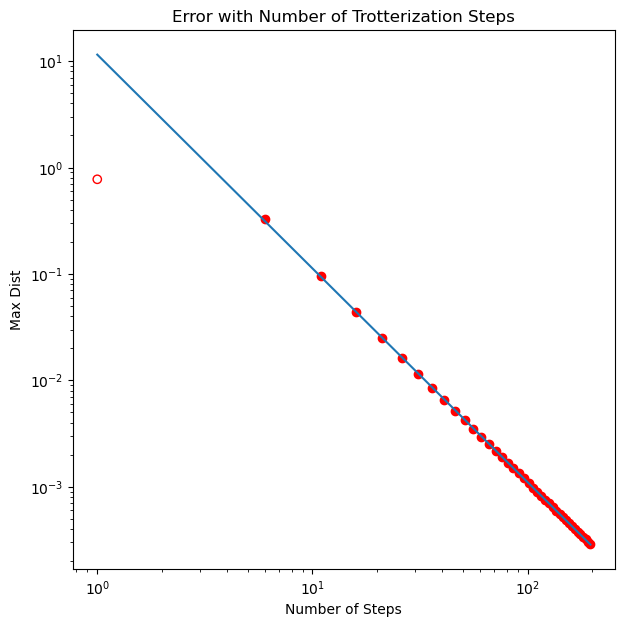

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (7, 7))

ax.plot(10**np.array(log_n_steps), 10**(np.array(log_n_steps) * m + b))
ax.scatter(step_counts[cutoff:], errors[cutoff:], c = "red")
ax.scatter(step_counts[:cutoff], errors[:cutoff], edgecolor = "red", facecolor = "None")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(left = 20)
# ax.set_ylim(0, 0.03)
ax.set_xlabel("Number of Steps")
ax.set_ylabel("Max Dist")
ax.set_title("Error with Number of Trotterization Steps")

In [98]:
data = np.array([step_counts, errors], [('step_count', int), ('error', float)])
np.save("second_order_H_XXZ_data", data)